In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

cross = nn.CrossEntropyLoss()

## Data Processing

In [4]:
x_train = pd.read_csv('./Data with correct player_atts/x_train.csv')
x_val = pd.read_csv('./Data with correct player_atts/x_val.csv')
x_test = pd.read_csv('./Data with correct player_atts/x_test.csv')

y_train = pd.read_csv('./Data with correct player_atts/y_train.csv')
y_val = pd.read_csv('./Data with correct player_atts/y_val.csv')
y_test = pd.read_csv('./Data with correct player_atts/y_test.csv')

x_train.shape, x_val.shape, x_test.shape

((8767, 53), (827, 53), (832, 53))

## Training

In [7]:
class LinearNN():
    def __init__(self, num_layers, sizes, activation_type, drop_out):
        self.model = self.n_layer_net(num_layers, sizes, activation_type, drop_out)
        self.activation_type = activation_type
        self.drop_out_p = drop_out
        self.num_layers = num_layers
        self.activation_type = activation_type
        
    
    def n_layer_net(self, num_layers, sizes, activation_type, drop_out):
        assert len(sizes) == num_layers
  
        if num_layers ==4:
            model = nn.Sequential(nn.Linear(input_size, sizes[0]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[0]), nn.Linear(sizes[0], sizes[1]),
                    activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[1]), nn.Linear(sizes[1], sizes[2]), activation_type, nn.Dropout(p=drop_out), 
                    nn.BatchNorm1d(sizes[2]), nn.Linear(sizes[2], sizes[3]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[3]), nn.Linear(sizes[3],
                    output_size), nn.Softmax(dim = 1)
                        )     
        elif num_layers ==5:
            model = nn.Sequential(nn.Linear(input_size, sizes[0]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[0]), nn.Linear(sizes[0], sizes[1]),
                    activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[1]), nn.Linear(sizes[1], sizes[2]), activation_type, nn.Dropout(p=drop_out), 
                    nn.BatchNorm1d(sizes[2]), nn.Linear(sizes[2], sizes[3]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[3]), nn.Linear(sizes[3],
                    sizes[4]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[4]), nn.Linear(sizes[4], output_size), nn.Softmax(dim = 1)
                        )  
        elif num_layers ==6:
            model = nn.Sequential(nn.Linear(input_size, sizes[0]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[0]), nn.Linear(sizes[0], sizes[1]),
                    activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[1]), nn.Linear(sizes[1], sizes[2]), activation_type, nn.Dropout(p=drop_out), 
                    nn.BatchNorm1d(sizes[2]), nn.Linear(sizes[2], sizes[3]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[3]), nn.Linear(sizes[3],
                    sizes[4]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[4]), nn.Linear(sizes[4], sizes[5]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[5]), nn.Linear(sizes[5], output_size), nn.Softmax(dim = 1)
                        )
        elif num_layers ==7:
            model = nn.Sequential(nn.Linear(input_size, sizes[0]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[0]), nn.Linear(sizes[0], sizes[1]),
                    activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[1]), nn.Linear(sizes[1], sizes[2]), activation_type, nn.Dropout(p=drop_out), 
                    nn.BatchNorm1d(sizes[2]), nn.Linear(sizes[2], sizes[3]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[3]), nn.Linear(sizes[3],
                    sizes[4]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[4]), nn.Linear(sizes[4], sizes[5]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[5]), nn.Linear(sizes[5], sizes[6]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[6]),  nn.Linear(sizes[6], output_size), nn.Softmax(dim = 1)
                        )
        elif num_layers ==8:
            model = nn.Sequential(nn.Linear(input_size, sizes[0]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[0]), nn.Linear(sizes[0], sizes[1]),
                    activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[1]), nn.Linear(sizes[1], sizes[2]), activation_type, nn.Dropout(p=drop_out), 
                    nn.BatchNorm1d(sizes[2]), nn.Linear(sizes[2], sizes[3]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[3]), nn.Linear(sizes[3],
                    sizes[4]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[4]), nn.Linear(sizes[4], sizes[5]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[5]), nn.Linear(sizes[5], sizes[6]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[6]),nn.Linear(sizes[6], sizes[7]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[7]),  nn.Linear(sizes[7], output_size), nn.Softmax(dim = 1)
                        )
        elif num_layers ==9:
            model = nn.Sequential(nn.Linear(input_size, sizes[0]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[0]), nn.Linear(sizes[0], sizes[1]),
                    activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[1]), nn.Linear(sizes[1], sizes[2]), activation_type, nn.Dropout(p=drop_out), 
                    nn.BatchNorm1d(sizes[2]), nn.Linear(sizes[2], sizes[3]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[3]), nn.Linear(sizes[3],
                    sizes[4]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[4]), nn.Linear(sizes[4], sizes[5]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[5]), nn.Linear(sizes[5], sizes[6]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[6]),nn.Linear(sizes[6], sizes[7]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[7]),nn.Linear(sizes[7], sizes[8]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[8]),  nn.Linear(sizes[8], output_size), nn.Softmax(dim = 1)
                        )
        elif num_layers ==10:
            model = nn.Sequential(nn.Linear(input_size, sizes[0]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[0]), nn.Linear(sizes[0], sizes[1]),
                    activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[1]), nn.Linear(sizes[1], sizes[2]), activation_type, nn.Dropout(p=drop_out), 
                    nn.BatchNorm1d(sizes[2]), nn.Linear(sizes[2], sizes[3]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[3]), nn.Linear(sizes[3],
                    sizes[4]), activation_type, nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[4]), nn.Linear(sizes[4], sizes[5]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[5]), nn.Linear(sizes[5], sizes[6]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[6]),nn.Linear(sizes[6], sizes[7]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[7]),nn.Linear(sizes[7], sizes[8]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[8]),nn.Linear(sizes[8], sizes[9]), activation_type, 
                    nn.Dropout(p=drop_out), nn.BatchNorm1d(sizes[9]),  nn.Linear(sizes[9], output_size), nn.Softmax(dim = 1)
                        )
        else:
            print('Invalid num_layers: choose between 4 and 10')
        return model

In [178]:
input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, [128,512,256,128,32], nn.ReLU(), 0.5),
'model6': LinearNN(5, [64,512,256,128,32], nn.ReLU(), 0),
'model7': LinearNN(6, [128,256,256,128,32,16], nn.ReLU(), 0.5),
'model8': LinearNN(6, [64,256,256,128,64,32], nn.ReLU(), 0),
'model9': LinearNN(6, [256,512,512,128,32,16], nn.ReLU(), 0.5),
'model10': LinearNN(7, [64,256,256,128,32,16,8], nn.ReLU(), 0.5),
'model11': LinearNN(7, [128,256,256,128,32,16,8], nn.ReLU(), 0),
'model12': LinearNN(7, [256,512,128,64,32,16,8], nn.ReLU(), 0.5),
'model13': LinearNN(8, [64,128,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(8, [128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(8, [256,512,512,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(9, [64,128,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(9, [128,256,256,128,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(9, [256,512,512,256,128,32,16,8,8], nn.ReLU(), 0.5),
'model13': LinearNN(10, [64,128,256,256,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model14': LinearNN(10, [128,256,256,512,256,128,64,32,16,8], nn.ReLU(), 0.5),
'model15': LinearNN(10, [256,512,512,256,256,128,32,16,8,8], nn.ReLU(), 0.5),
}

## Ensemble Learning

In [314]:
def train(model, X_train, Y_train, X_val, Y_val, epochs, batch_size, learning_rate):
    StandardScaler = preprocessing.StandardScaler().fit(X_train.iloc[:,1:])
    X_train = pd.DataFrame(StandardScaler.transform(X_train.iloc[:,1:]), index = X_train['match_api_id'], columns = X_train.iloc[:,1:].columns)
    X_val = pd.DataFrame(StandardScaler.transform(X_val.iloc[:,1:]), index = X_val['match_api_id'], columns = X_val.iloc[:,1:].columns)
    
    loss, counter = 0, 0
    losses_train, losses_val = [], []

    dataset = TensorDataset(Tensor(X_train.values), torch.Tensor(Y_train['target'].values))
    train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.999), weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 25 , gamma = 0.1)
    
    #Train Model
    t = time.time()
    for epoch in range(epochs):
        for x, y in iter(train_loader):
            model.train()
            model.zero_grad()
            
            #forward
            y_pred = model(x)
            loss = cross(y_pred, y.long())
 
            #backward + update
            loss.backward()
            optimizer.step()
            
            #store errors
            with torch.no_grad():
                y_train_pred = model(Tensor(X_train.values))
                y_val_pred = model(Tensor(X_val.values))
                
                loss_train = cross(y_train_pred, Tensor(Y_train['target'].values).long())
                loss_val = cross(y_val_pred, Tensor(Y_val['target'].values).long())
                
                losses_train.append(loss_train.item())
                losses_val.append(loss_val.item())
                
                
            if counter % 100 ==0:
                print('Loss after iteration {}: {}'.format(counter, loss_train.item()))
                
            counter+=1 
        scheduler.step()
    time.time()-t        
    
    ##Returns train/val accuracy/losses, the losses during the training for plotting, the prediction probabilities to be used for ensemble stuff
    return list(evaluate(model, X_train, Y_train)) + list(evaluate(model, X_val, Y_val)), (losses_train, losses_val), (y_train_pred,y_val_pred) 

def evaluate(model, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(Tensor(x.values))
    global pred_results 
    pred_results = pd.Series(pred.max(1).indices)

    return sklearn.metrics.accuracy_score(pred_results, y['target']), log_loss(y['target'], pred) 

In [311]:
input_size = len(x_train.drop(columns ='match_api_id').columns)
output_size = 3

model_dict = {

'model4': LinearNN(5, [128,256,128,32,16], nn.ReLU(), 0.5),
'model5': LinearNN(5, [128,512,256,128,32], nn.ReLU(), 0.5)}


In [317]:
splits = 3
kf = KFold(n_splits=splits, random_state=1, shuffle=True)

results = pd.DataFrame(data = 0, index = model_dict.keys(), columns = ['t_acc', 't_loss', 'v_acc', 'v_loss'])
x_ens = pd.DataFrame(data =  0, index = x_train.index, columns = [])
train_ens_dict = {}
big_losses_list = []


for model_name in model_dict:
    
    model = model_dict[model_name].model
    x_train_ens = pd.DataFrame(data = 0, index = x_train.index, columns = ['{}_0'.format(model_name), '{}_1'.format(model_name), '{}_2'.format(model_name)])

    print(model_name)
    
    for train_index, val_index in kf.split(x_train):    
        
        X_train, X_val = x_train[x_train.index.isin(train_index)], x_train[x_train.index.isin(val_index)]
        Y_train, Y_val = y_train[y_train.index.isin(train_index)], y_train[y_train.index.isin(val_index)]
        
        results_list, losses, all_pred = train(model, X_train, Y_train, X_val, Y_val,  2, len(X_train), 0.001)
        results.loc[model_name, :] = results.loc[model_name, :].add(results_list)
        big_losses_list.append(losses)
   
        x_train_ens.loc[x_train_ens.index.isin(train_index), :] += (np.array(all_pred[0]))
        x_train_ens.loc[x_train_ens.index.isin(val_index), :] += (np.array(all_pred[1]))
        
    train_ens_dict[model_name] = x_train_ens/splits
    x_ens = pd.concat([x_ens, train_ens_dict[model_name]], axis = 1)
    
results /= splits
results

model4
Loss after iteration 0: 1.0974276065826416
Loss after iteration 0: 1.0948771238327026
Loss after iteration 0: 1.095057487487793
model5
Loss after iteration 0: 1.0869423151016235
Loss after iteration 0: 1.080271601676941
Loss after iteration 0: 1.0774931907653809


,t_acc,t_loss,v_acc,v_loss
model4,0.348807,1.084618,0.346756,1.084636
model5,0.271814,1.116006,0.269079,1.116072


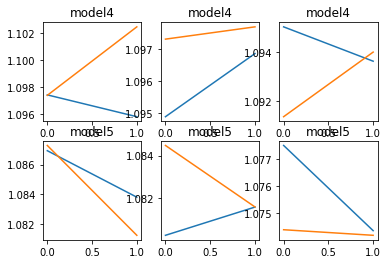

In [322]:
fig, axes = plt.subplots(nrows=len(model_dict), ncols=splits)
for i, ax in enumerate(axes.flatten()):
    if i < len(big_losses_list):
        ax.plot(big_losses_list[i][0])
        ax.plot(big_losses_list[i][1])
        ax.set_title(results.index[math.floor(i/kf.n_splits)])


In [180]:
def save_models(models):
    for model in models:
        torch.save(model_dict[model].model, './NN Models/{}.pt'.format(model))

In [350]:
def ensemble_predict(models, x, y, scaler):
    global pred_ensemble, y_ens
    
    pred_ensemble = 0
    X = pd.DataFrame(scaler.transform(x.iloc[:,1:]), index = x['match_api_id'], columns = x.iloc[:,1:].columns)
    
    for i,model in enumerate(models):
        model.eval()
        with torch.no_grad():
            pred = model(Tensor(X.values))
            pred_ensemble += pred

        
    
    y_ens = pd.Series(pred_ensemble.max(1).indices)
    print('Ensemble Val accuracy: {}'.format(sklearn.metrics.accuracy_score(y_ens, y['target'])))


In [355]:
ensemble_predict([model_dict['model4'].model, model_dict['model5'].model], x_train, y_train, preprocessing.StandardScaler().fit(x_train.iloc[:,1:]))

Ensemble Val accuracy: 0.28995095243526864
